In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix
    
from metrics import precision_at_k, recall_at_k

from IPython.display import clear_output

In [6]:
!pip install implicit
clear_output()
print('install successfully')

install successfully


In [7]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

### ALS with grid-search

#### Подготовка данных

In [9]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [99]:
data = pd.read_csv('/content/gdrive/MyDrive/mayo/recommendations/data/transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [100]:
item_features = pd.read_csv('/content/gdrive/MyDrive/mayo/recommendations/data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [101]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [102]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999_999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)

user_item_matrix.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820347,820361,820486,820518,820560,820895,821025,821083,821200,821209,821219,821344,...,14025461,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452531,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15629778,15716445,15716719,15717057,15741861,15777852,15778533,15831255,15926712,15926725,15926775,15926844,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Сопоставим продуктовый id со строчным id
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

# ALS

Будем перебирать с помощью ручного grid-search параметры:
- factors
- regularization

для 3 матриц:
- обычная sparse matrix
- sparse matrix, взвешенная с помощью TF-IDF
- sparse matrix, взвешенная с помощью BM25

In [104]:
def func_id_to_itemid(row):
    return [id_to_itemid[id] for id in row]

In [105]:
def train_als_model(user_item_matrix, weighting, factors, regularization, history):
    assert weighting in weighting_list, f"Invalid type for weighting. Valid types: {weighting_list}"
    
    name = f"{weighting}_{factors}_{regularization}"
    print(name)
    
    if weighting == 'tf_idf':
        user_item_matrix = tfidf_weight(user_item_matrix.T).T
    elif weighting == 'bm25':
        user_item_matrix = bm25_weight(user_item_matrix.T).T
    
    model = AlternatingLeastSquares(factors=factors, 
                                    regularization=regularization,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=0,
                                    use_gpu=False)
    
    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)

    # Использую recommend_all, потому что это быстрее построчных рекомендаций
    recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=False, 
                                      filter_items=[itemid_to_id[999_999]], 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)
    
    # Оставим только те id, которые есть в тесте
    recommendations = recommendations[np.array(result['user_id'].values) - 1]
    # Переведем все строковые id в продуктовые id
    recommendations = np.apply_along_axis(func_id_to_itemid, 1, recommendations)
    result[name] = recommendations.tolist()

    precision = result.apply(lambda row: precision_at_k(row[name], row['actual']), axis=1).mean()
    
    history = np.vstack((history,
                         np.array([[weighting, factors, regularization, precision]])))
    
    return history

In [106]:
history = np.empty((0, 4))

weighting_list = ['standard', 'tf_idf', 'bm25']
factors_list = [32, 64, 128]
regularization_list = [0.01, 0.05, 0.1]

for weighting in weighting_list:
    for factors in factors_list:
        for regularization in regularization_list:
            history = train_als_model(user_item_matrix, weighting, factors, regularization, history)

standard_32_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_32_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_32_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_64_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_64_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_64_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_128_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_128_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

standard_128_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_32_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_32_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_32_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_64_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_64_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_64_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_128_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_128_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

tf_idf_128_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_32_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_32_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_32_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_64_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_64_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_64_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_128_0.01


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_128_0.05


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

bm25_128_0.1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

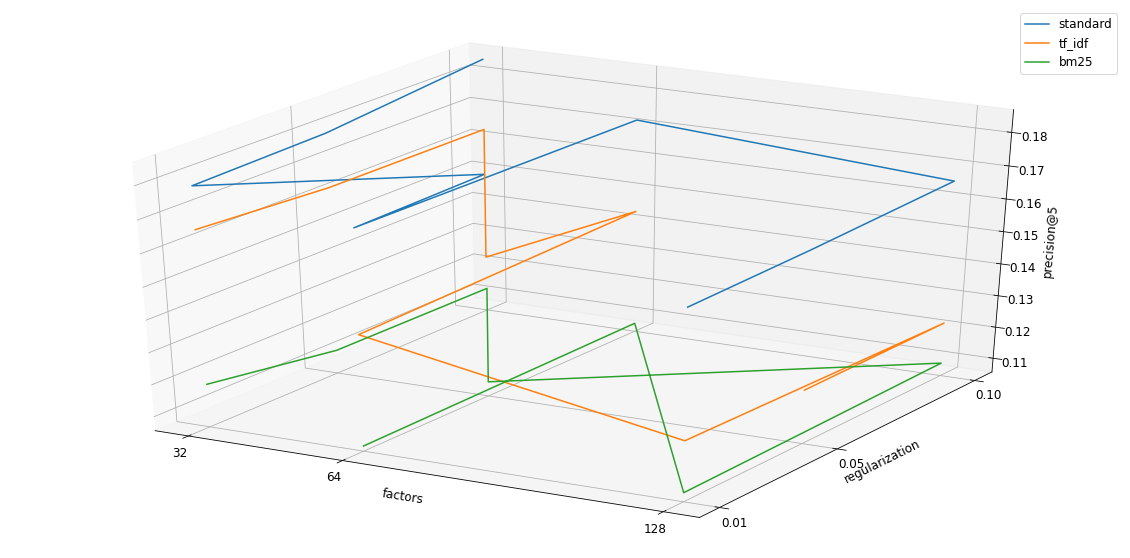

In [146]:
# ax = plt.axes(projection='3d')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

weighting_list = ['standard', 'tf_idf', 'bm25']

for weighting in weighting_list:
    xline = pd_history[pd_history['weighting']==weighting]['factors'].to_list()
    yline = pd_history[pd_history['weighting']==weighting]['regularization'].to_list()
    zline = pd_history[pd_history['weighting']==weighting]['precision@5'].to_list()
    ax.plot3D(xline, yline, zline, label=weighting)

ax.set_xlabel('factors')
ax.set_ylabel('regularization')
ax.set_zlabel('precision@5')

ax.set_xticks(factors_list)
ax.set_yticks(regularization_list)

plt.legend()

In [134]:
pd_history = pd.DataFrame(history, columns=['weighting', 'factors', 'regularization', 'precision@5'])

pd_history['factors'] = pd_history['factors'].astype('int')
pd_history['regularization'] = pd_history['regularization'].astype('float')
pd_history['precision@5'] = pd_history['precision@5'].astype('float')

pd_history.sort_values(by='precision@5', ascending=False, inplace=True)
pd_history

,weighting,factors,regularization,precision@5
2,standard,32,0.10,0.185133
1,standard,32,0.05,0.180110
0,standard,32,0.01,0.179006
4,standard,64,0.05,0.174083
3,standard,64,0.01,0.173280
5,standard,64,0.10,0.172577
8,standard,128,0.10,0.166449
9,tf_idf,32,0.01,0.166148
7,standard,128,0.05,0.164741
6,standard,128,0.01,0.163938
